<a href="https://colab.research.google.com/github/OpenForest4D/ALS_Notebooks/blob/main/forest_canopy_gap_detection_CHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forest Canopy Gap Detection from CHM**

This R notebook reads a canopy height model (CHM) raster dataset, detects forest canopy gaps based on a height threshold and area limits, computes per-gap statistics, converts them to polygons with centroids, and visualizes the gaps in the forest canopy.

This work was supported by the National Science Foundation under awards 2409885, 2409886 & 2409887. - www.openforest4d.org

Authors: Kai Lin, Viswanath Nandigam, Carlos Alberto Silva

**Step 0: Install and Load Packages**

A compressed package containing all required libraries is available for download to save setup time. Alternatively, you may install the libraries individually, although this process can take up to 15-20 minutes.

In [3]:
# Option 1: Download compressed package containing all required libraries

download.file("https://zenodo.org/records/17611774/files/forestlib.tar.gz", destfile = "forestlib.tar.gz", mode = "wb")
untar("forestlib.tar.gz", exdir = ".")

# Add forestlib to R library search path
.libPaths("forestlib")

# Install pacman only if not available
if (!requireNamespace("pacman", quietly = TRUE)) {
install.packages("pacman")
}

# Load packages using pacman for easier management in Colab WITHOUT reinstalling
pacman::p_load(
  terra,       # Raster handling
  sf,          # Simple features
  install = FALSE,
  update = FALSE
)

pacman::p_load(
    png,      # Display PNG bitmap images
    grid      # Vector graphics
)

# Option 2: Install libraries individually ()

# # Set CRAN mirror once globally
# options(repos = "https://cran.rstudio.com/")

# # Install pacman only if not available
# if (!requireNamespace("pacman", quietly = TRUE)) {
#   install.packages("pacman")
# }

# # Load packages using pacman for easier management in Colab
# pacman::p_load(
#   terra,       # Raster handling
#   sf,          # Simple features
#   png,         # Display PNG bitmap images
#   grid         # Vector graphics
#   #viridis     # Optional for Color palettes in plots
# )


**Step 1: Define Core Utility Functions**

*detect_gaps*: classifies CHM cells below the height threshold as gaps, identifies connected patches with terra::patches, computes patch areas, filters them to the specified min/max area range, and returns a labeled raster of final gap patches (gap_id)

*gap_statistics*: builds a table of gap area (m²) from cell counts and resolution, then aggregates CHM values per gap to get min, mean, max, and standard deviation, returning a gap-level stats data frame.

*gaps_to_polygons*: converts the gap raster to polygons, casts to sf, and adds centroid coordinates (x,y) for each gap polygon.

In [7]:
# detect_gaps: Detects CHM gaps below the height threshold, groups them with terra::patches, filters by area limits, and outputs a labeled gap raster.

detect_gaps <- function(chm, threshold = 10, min_size = 1, max_size = 10000) {
  # Classify cells: NA if tall (above threshold), 1 if gap (below threshold)
  gap_mask <- chm
  gap_mask[gap_mask > threshold] <- NA
  gap_mask[gap_mask <= threshold] <- 1

  # Check if any gaps exist at all
  if (all(is.na(gap_mask[]))) {
    cat("No areas found below threshold of", threshold, "meters\n")
    return(NULL)
  }

  # Identify connected gap patches
  patches <- terra::patches(gap_mask, directions = 8, allowGaps = FALSE)

  # Calculate patch sizes in m²
  freq_table <- terra::freq(patches)
  freq_table$layer <- NULL
  freq_table[, 2] <- freq_table[, 2] * terra::res(chm)[1]^2

  # Filter by size range
  sizes <- terra::classify(patches, rcl = freq_table, right = FALSE)
  patches[is.na(patches)] <- NA
  patches[sizes > max_size] <- NA
  patches[sizes < min_size] <- NA

  # Check if any gaps remain after filtering
  if (all(is.na(patches[]))) {
    cat("No gaps found matching size criteria (min:", min_size, "m², max:", max_size, "m²)\n")
    return(NULL)
  }

  # Re-identify connected patches after filtering
  final_gaps <- terra::patches(patches, directions = 8, allowGaps = FALSE)
  names(final_gaps) <- "gap_id"

  return(final_gaps)
}

# gap_statistics: Computes gap area (m²) from cell counts and resolution, then summarizes CHM per gap (min, mean, max, SD) into a gap-level stats table.

gap_statistics <- function(gap_raster, chm) {

  # Check if gap_raster is NULL or empty
  if (is.null(gap_raster) || all(is.na(gap_raster[]))) {
    return(NULL)
  }

  # Extract gap sizes
  gap_freq <- data.frame(terra::freq(gap_raster))
  gap_freq$layer <- NULL
  gap_freq$gap_area <- gap_freq$count * terra::res(gap_raster)[1]^2
  gap_freq <- gap_freq[!is.na(gap_freq[, 1]), ]
  colnames(gap_freq) <- c("gap_id", "count", "gap_area")
  gap_freq$count <- NULL

  # Extract CHM statistics for each gap
  chm_stats <- stats::aggregate(chm[],
                               by = list(gap_raster[]),
                               FUN = function(x) c(
                                 min = min(x, na.rm = TRUE),
                                 mean = mean(x, na.rm = TRUE),
                                 max = max(x, na.rm = TRUE),
                                 sd = sd(x, na.rm = TRUE)
                               ))

  chm_stats <- data.frame(cbind(chm_stats[, 1], chm_stats[, 2]))
  colnames(chm_stats) <- c("gap_id", "chm_min", "chm_mean", "chm_max", "chm_sd")
  chm_stats[, 2:5] <- round(chm_stats[, 2:5], 2)

  # Merge all statistics
  gap_stats <- merge(gap_freq, chm_stats, by = "gap_id")
  return(gap_stats)
}

# gaps_to_polygons: converts the gap raster to polygons, casts to sf, and adds centroid coordinates (x,y) for each gap polygon.

gaps_to_polygons <- function(gap_raster) {

  # Check if gap_raster is NULL or empty
  if (is.null(gap_raster) || all(is.na(gap_raster[]))) {
    return(NULL)
  }

  gaps_poly <- terra::as.polygons(gap_raster, dissolve = TRUE,
                                  na.rm = TRUE, values = TRUE)
  names(gaps_poly) <- "gap_id"
  gaps_sf <- sf::st_as_sf(gaps_poly)

  # Add centroids
  centroids <- suppressWarnings(sf::st_centroid(gaps_sf))
  gaps_sf$centroid_x <- sf::st_coordinates(centroids)[, 1]
  gaps_sf$centroid_y <- sf::st_coordinates(centroids)[, 2]

  return(gaps_sf)
}


**Step 2: Load Sample CHM Data and Visualize**

Load a sample Canopy Height Model GeoTIFF, inspect dimensions and extent, and plot it with a custom color ramp.

Users can also generate a CHM on demand over their area of interest via the OpenForest4D portal. https://openforest4d.org/ (USGS 3D Elevation Profile Forest Structure Metrics Service)

✓ CHM sample file downloaded

Loading CHM raster...
✓ CHM loaded
  Dimensions: 295 x 438 
  Extent: ext(-13550162, -13549724, 4356219, 4356514) 



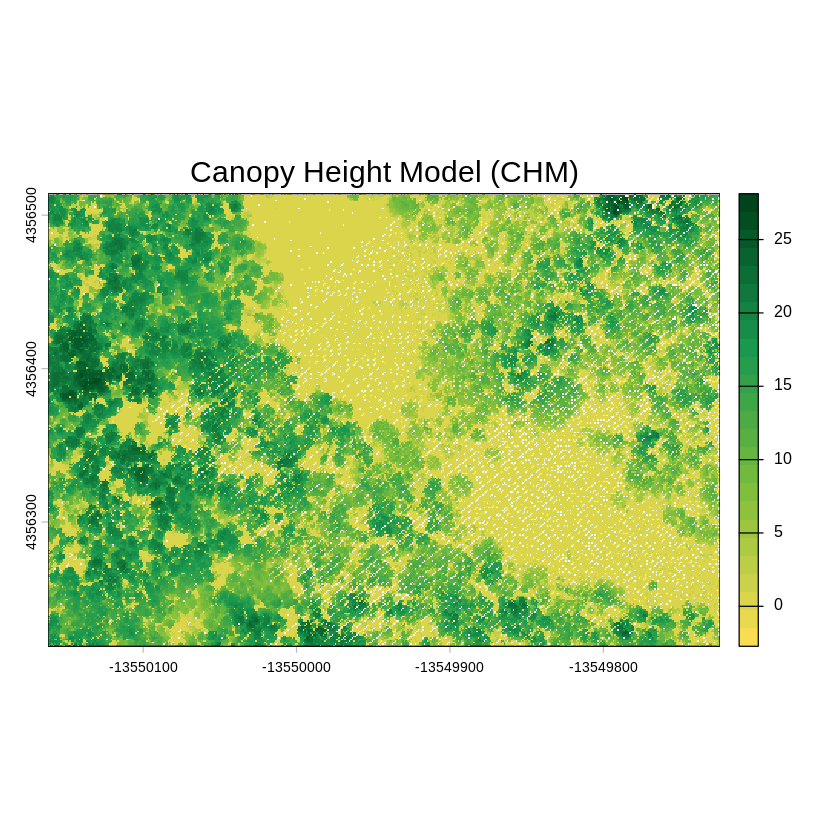

In [9]:
# Download the sample CHM, load it with terra::rast(), check its dimensions and extent, then plot it using a custom color ramp.

cat("Downloading CHM sample file...\n")
chm_url <- "https://github.com/OpenForest4D/ALS_Notebooks/raw/refs/heads/main/samples/chm.tif"
chm_file <- "chm.tif"

download.file(chm_url, destfile = chm_file, mode = "wb")
cat("✓ CHM sample file downloaded\n\n")

# Load the CHM raster
cat("Loading CHM raster...\n")
chm <- terra::rast(chm_file)
cat("✓ CHM loaded\n")
cat("  Dimensions:", nrow(chm), "x", ncol(chm), "\n")
cat("  Extent:", as.character(terra::ext(chm)), "\n\n")

# Creates a smooth green-yellow gradient (25 colors) for CHM height visualization
col <- colorRampPalette(c("#F9DD50", "#7FBF3B", "#1A9850", "#00441B"))(25)

# Plots the chm raster using the custom colormap.
plot(chm, col = col, main = "Canopy Height Model (CHM)", cex.main = 1.5, font.main = 1)

**Step 3: Calculate gap detection, gap statistics and print tabular output**

Calls detect_gaps on this CHM with given threshold, min_size, and max_size.
Runs gap_statistics to compute, for each gap_id, its area and CHM statistics (min/mean/max/sd canopy height inside the gap)
Prints or views a large gap statistics table where each row is a gap, with columns like gap_id, gap_area, chm_min, chm_mean, chm_max, and chm_sd.

In [10]:
cat("Detecting forest canopy gaps...\n")

# Detect gaps
gaps <- detect_gaps(chm, threshold = 10, min_size = 1, max_size = 10000)

# Calculate statistics
gaps_stats <- gap_statistics(gaps, chm)

# Convert to polygons
gaps_sf <- gaps_to_polygons(gaps)
gaps_sf <- merge(gaps_sf, gaps_stats, by = "gap_id")

cat("Detecting is done\n")

cat("\n=== GAP STATISTICS ===\n")
print(gaps_stats)

cat("\n=== SPATIAL FEATURES ===\n")
print(gaps_sf[, c("gap_id", "centroid_x", "centroid_y")])

Detecting forest canopy gaps...
Detecting is done

=== GAP STATISTICS ===
     gap_id gap_area chm_min chm_mean chm_max chm_sd
1         1        1    0.05     0.05    0.05     NA
2         2        1    9.03     9.03    9.03     NA
3         3        1    0.00     0.00    0.00     NA
4         4      542   -0.08     2.95    9.98   3.21
5         5        1   -0.05    -0.05   -0.05     NA
6         6      112   -0.05     4.05    9.85   3.88
7         7        1    0.04     0.04    0.04     NA
8         8        1    6.34     6.34    6.34     NA
9         9        2   -0.06    -0.02    0.01   0.06
10       10        1    0.06     0.06    0.06     NA
11       11        1   -0.02    -0.02   -0.02     NA
12       12        1    0.05     0.05    0.05     NA
13       13       23    0.01     5.65    9.88   3.94
14       14        1    0.03     0.03    0.03     NA
15       15        1    0.10     0.10    0.10     NA
16       16        1   -0.03    -0.03   -0.03     NA
17       17        1   -0

**Step 4: Polygon conversion, export, and visualization**

Converts the gap raster to polygons with gaps_to_polygons, getting an sf object with gap IDs and centroid coordinates.

Overlays these gap polygons on the CHM: plots the CHM background, then adds semi-transparent red polygons for gaps and writes the composite to canopy_gaps.png, which is then visualized.

agg_record_1505951876 
                    2

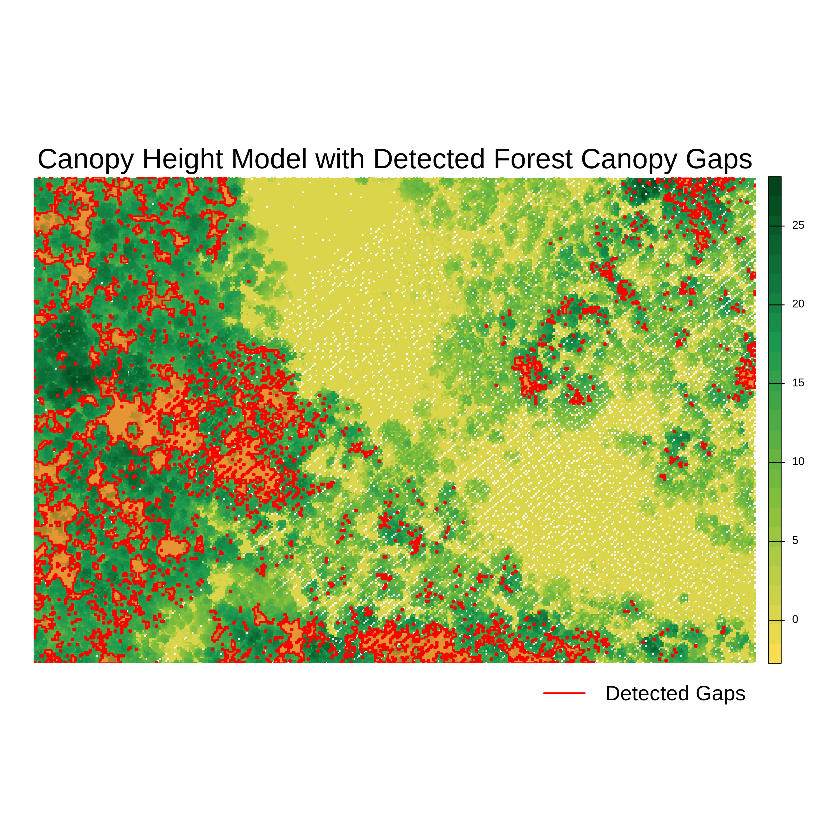

In [11]:
# PNG output setup. Adjusts plot margins: bottom=4, left=4, top=5, right=6 lines (extra right space for legend)

png("canopy_gaps.png", width=3000, height=2400, res=300)
par(mar=c(4,4,5,6))

# Creates a smooth green-yellow gradient (25 colors) for CHM height visualization
col <- colorRampPalette(c("#F9DD50", "#7FBF3B", "#1A9850", "#00441B"))(25)

# Plots the chm raster (assumed RasterLayer from raster or terra package) using the custom colormap
plot(chm,
     col  = col,
     axes = FALSE,
     box  = FALSE,
     main = "Canopy Height Model with Detected Forest Canopy Gaps",
     cex.main = 2,
     font.main = 1
)

#Overlay Gaps - Adds gaps_sf (sf simple features polygons) on top.

suppressWarnings(
  plot(gaps_sf,
       add    = TRUE,
       border = "red",
       col    = rgb(1, 0, 0, 0.3),  # semi‑transparent red fill
       lwd    = 2)
)

#Places a simple line legend in bottom-right corner

legend("bottomright",  # or "topright"
       legend = "Detected Gaps",
       col    = "red",
       lwd    = 2,
       bty    = "n",
       cex    = 1.5,
       xpd    = TRUE)

# Finalize and display

dev.off()
img <- readPNG("canopy_gaps.png")
grid.raster(img)
